svm accuracy:  89.0
kNN opencv accuracy:  87.0
kNN sklearn accuracy:  87.0
Epoch 1/20
10/10 [==============================] - 14s 1s/step - loss: 1.9252 - accuracy: 0.3133 - val_loss: 1.0583 - val_accuracy: 0.6700
Epoch 2/20
10/10 [==============================] - 12s 1s/step - loss: 0.6934 - accuracy: 0.8133 - val_loss: 0.5062 - val_accuracy: 0.8700
Epoch 3/20
10/10 [==============================] - 12s 1s/step - loss: 0.2799 - accuracy: 0.9200 - val_loss: 0.6340 - val_accuracy: 0.8600
Epoch 4/20
10/10 [==============================] - 11s 1s/step - loss: 0.0949 - accuracy: 0.9733 - val_loss: 0.7356 - val_accuracy: 0.8500
Epoch 5/20
10/10 [==============================] - 11s 1s/step - loss: 0.0551 - accuracy: 0.9833 - val_loss: 0.4395 - val_accuracy: 0.9200
Epoch 6/20
10/10 [==============================] - 11s 1s/step - loss: 0.0184 - accuracy: 0.9967 - val_loss: 0.9245 - val_accuracy: 0.8300
Epoch 7/20
10/10 [==============================] - 12s 1s/step - loss: 0.0149 - accu

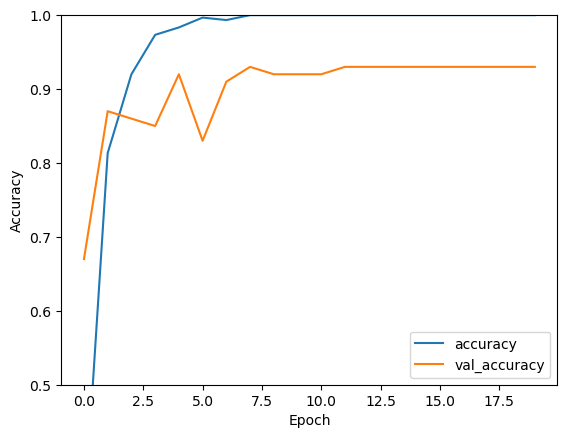

In [101]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

img = cv.imread(cv.samples.findFile('pic.jpg'),0)
if img is None:
    raise Exception("we need the digits.png image from samples/data here !")

#prepare image
ret, img = cv.threshold(img,135,255,cv.THRESH_BINARY)
img = np.invert(img)
SIZE = 1360
ROWS = 20
COLUMNS = 20
LABELS = ['a', 'b', 'c', 'd', 'e','f', 'g', 'h', 'k','l']
ROWS_PER_LABEL=2
CELL_SIZE = SIZE//ROWS

assert SIZE/COLUMNS == CELL_SIZE
TRAIN_COLUMNS = 15
TEST_COLUMNS = COLUMNS-TRAIN_COLUMNS
img = cv.resize(img, (SIZE,SIZE))
bin_n = 16 # Number of bins
affine_flags = cv.WARP_INVERSE_MAP|cv.INTER_LINEAR

def deskew(img):
    m = cv.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*CELL_SIZE*skew], [0, 1, 0]])
    img = cv.warpAffine(img,M,(CELL_SIZE, CELL_SIZE),flags=affine_flags)
    return img

def hog(img):
    gx = cv.Sobel(img, cv.CV_32F, 1, 0)
    gy = cv.Sobel(img, cv.CV_32F, 0, 1)
    mag, ang = cv.cartToPolar(gx, gy)
    bins = np.int32(bin_n*ang/(2*np.pi))    # quantizing binvalues in (0...16)
    bin_cells = bins[:CELL_SIZE//2,:CELL_SIZE//2], bins[CELL_SIZE//2:,:CELL_SIZE//2], bins[:CELL_SIZE//2,CELL_SIZE//2:], bins[CELL_SIZE//2:,CELL_SIZE//2:]
    mag_cells = mag[:CELL_SIZE//2,:CELL_SIZE//2], mag[CELL_SIZE//2:,:CELL_SIZE//2], mag[:CELL_SIZE//2,CELL_SIZE//2:], mag[CELL_SIZE//2:,CELL_SIZE//2:]
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)  # hist is a 64 bit vector
    return hist

while True:
    cv.imshow('img', cv.resize(img, (400,400)))
    if cv.waitKey(1) == ord('q'):
        break
cv.destroyAllWindows()
cells = [np.hsplit(row,COLUMNS) for row in np.vsplit(img,ROWS)]

#Prepare train data
train_cells = [ i[:TRAIN_COLUMNS] for i in cells] 
deskewed = [list(map(deskew,row)) for row in train_cells]
hogdata = [list(map(hog,row)) for row in deskewed]
trainData = np.float32(hogdata).reshape(-1,64)
trainLabels = np.repeat(np.arange(len(LABELS)),TRAIN_COLUMNS*ROWS_PER_LABEL)[:,np.newaxis]

#prepare test data
test_cells = [ i[TRAIN_COLUMNS:] for i in cells ]
deskewed = [list(map(deskew,row)) for row in test_cells]
hogdata = [list(map(hog,row)) for row in deskewed]
testData = np.float32(hogdata).reshape(-1,bin_n*4)
testLabels = np.repeat(np.arange(len(LABELS)),TEST_COLUMNS*ROWS_PER_LABEL)[:,np.newaxis]

# svm
svm = cv.ml.SVM_create()
svm.setKernel(cv.ml.SVM_LINEAR)
svm.setType(cv.ml.SVM_C_SVC)
svm.setC(2.67)
svm.setGamma(5.383)
svm.train(trainData, cv.ml.ROW_SAMPLE, trainLabels)
svm.save('svm_data.dat')
results = svm.predict(testData)[1]
mask = results==testLabels
correct = np.count_nonzero(mask)
print("svm accuracy: ", correct*100.0/results.size)

#kNN opencv
knn = cv.ml.KNearest_create()
knn.train(trainData, cv.ml.ROW_SAMPLE, trainLabels)
ret, results, neighbours ,dist = knn.findNearest(testData, 3)
mask = results==testLabels
correct = np.count_nonzero(mask)
print("kNN opencv accuracy: ", correct*100.0/results.size)

#kNN sklearn
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(trainData, trainLabels.reshape(-1))
results = neigh.predict(testData)
mask = results.reshape(-1,1)==testLabels
correct = np.count_nonzero(mask)
print("kNN sklearn accuracy: ", correct*100.0/results.size)         

#CNN
train_cells = np.array(train_cells).reshape(ROWS*TRAIN_COLUMNS, CELL_SIZE, CELL_SIZE)/255.0
test_cells = np.array(test_cells).reshape(ROWS*TEST_COLUMNS, CELL_SIZE, CELL_SIZE)/255.0
# print(train_cells.shape)
# print(trainLabels.shape)
# plt.figure(figsize=(5,120))
# for i in range(ROWS*TRAIN_COLUMNS):
#     plt.subplot(ROWS*len(LABELS),TRAIN_COLUMNS,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(train_cells[i], cmap ='gray')
#     plt.xlabel(LABELS[trainLabels[i][0]])
# plt.show()

model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(CELL_SIZE,CELL_SIZE, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(len(LABELS)))
#model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_cells.reshape(-1,CELL_SIZE, CELL_SIZE,1), trainLabels, epochs=20, 
                    validation_data=(test_cells.reshape(-1,CELL_SIZE, CELL_SIZE,1), testLabels))
                
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_cells.reshape(-1,CELL_SIZE, CELL_SIZE,1), testLabels, verbose=2)
print ("CNN accuracy: ", test_acc)
